Представьте, что вы работаете в государственной компании, предоставляющей анализ экономической ситуации в мире по заказу государства.

Перед вами стоит задача проанализировать ВВП африканской страны Гана. Для этого вам предоставили показатели ВВП Ганы за 62 года. Вам предстоит исследовать временной ряд, изучить его свойства, построить модели и сделать выводы по результатам.

In [1]:
from warnings import filterwarnings

In [2]:
filterwarnings("ignore")

In [8]:
import pandas as pd

data = pd.read_csv("data/ghana_gdp.csv", parse_dates=["year"], index_col=["year"])
data.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


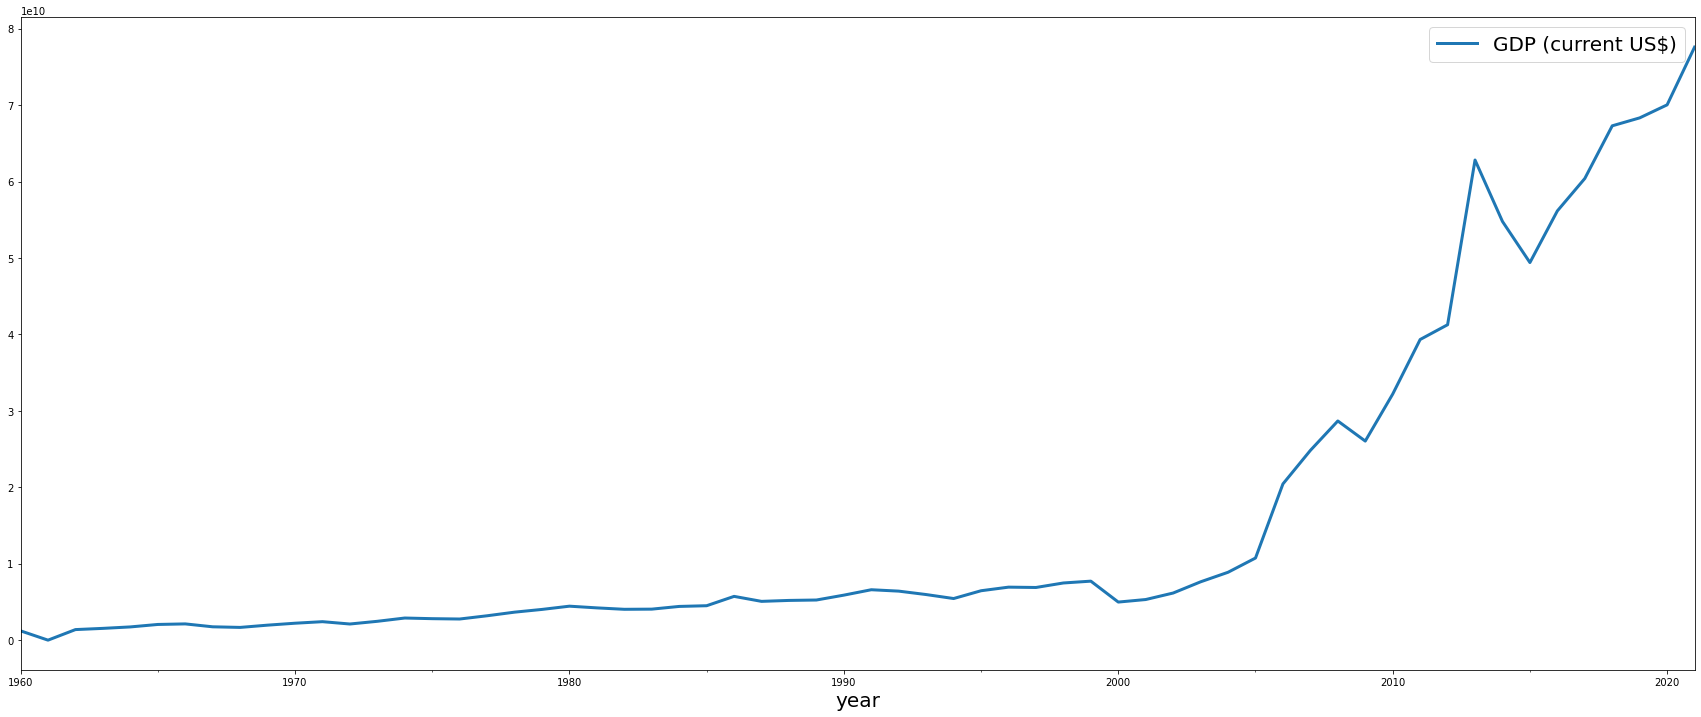

In [9]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

data.plot()
plt.show()

In [76]:
train_df = data.iloc[:-3]
test_df = data.iloc[-3:]
train_df.shape, test_df.shape

((59, 1), (3, 1))

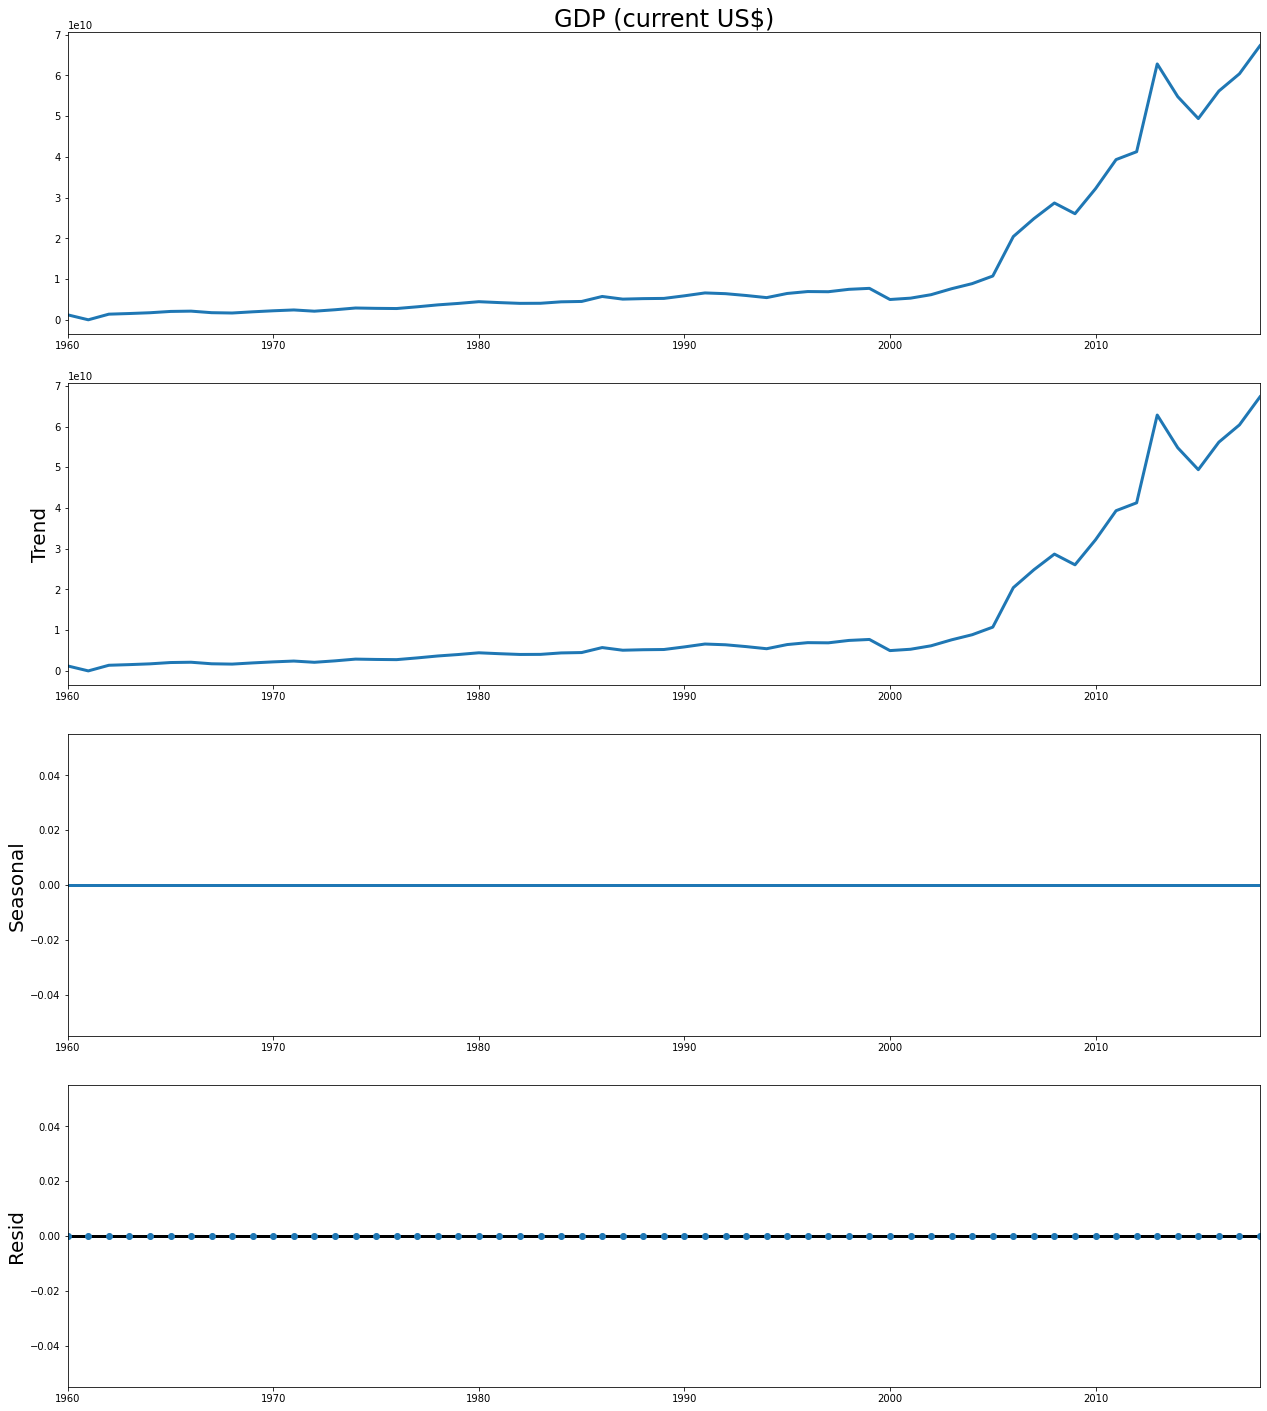

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(train_df['GDP (current US$)'])
result.plot()
plt.show()

График четко показывает отсутствие сезонности. Что мы подтверждаем после декомпрессии данных.

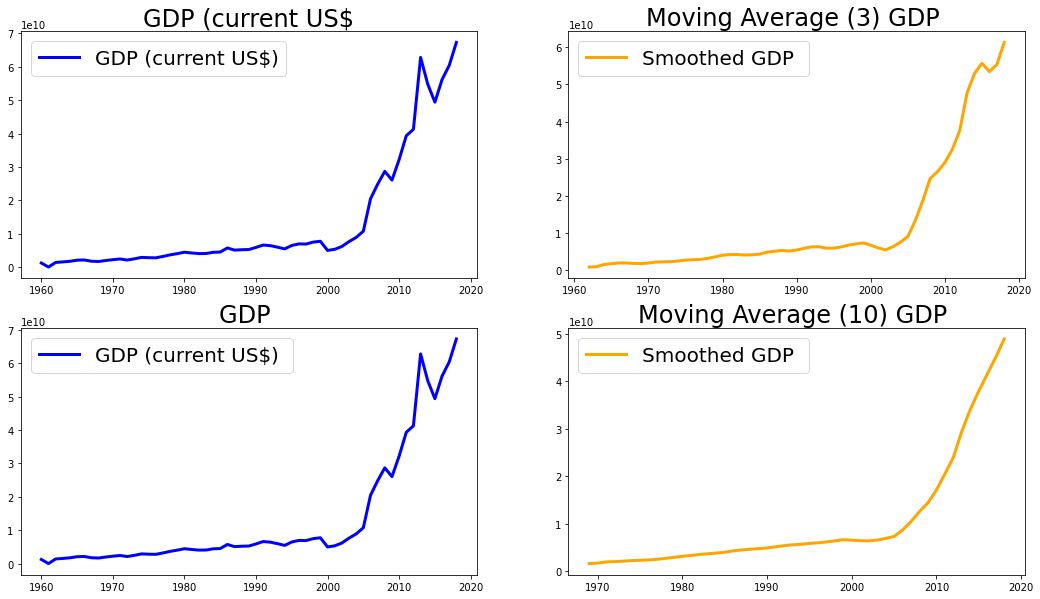

In [28]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

# Окно в месяц (Window = 3)
ax[0, 0].plot(train_df['GDP (current US$)'], color="blue", label="GDP (current US$)")
ax[0, 0].set_title("GDP (current US$", size=24)
ax[0, 0].legend()

ax[0, 1].plot(
    train_df['GDP (current US$)'].rolling(window=3).mean(),
    color="orange",
    label="Smoothed GDP ",
)

ax[0, 1].set_title("Moving Average (3) GDP ", size=24)
ax[0, 1].legend()


# Окно в год (Window = 10)
ax[1, 0].plot(train_df['GDP (current US$)'], color="blue", label="GDP (current US$) ")
ax[1, 0].set_title("GDP ", size=24)
ax[1, 0].legend()

ax[1, 1].plot(
    train_df['GDP (current US$)'].rolling(window=10).mean(),
    color="orange",
    label="Smoothed GDP ",
)

ax[1, 1].set_title("Moving Average (10) GDP ", size=24)
ax[1, 1].legend()

plt.show()

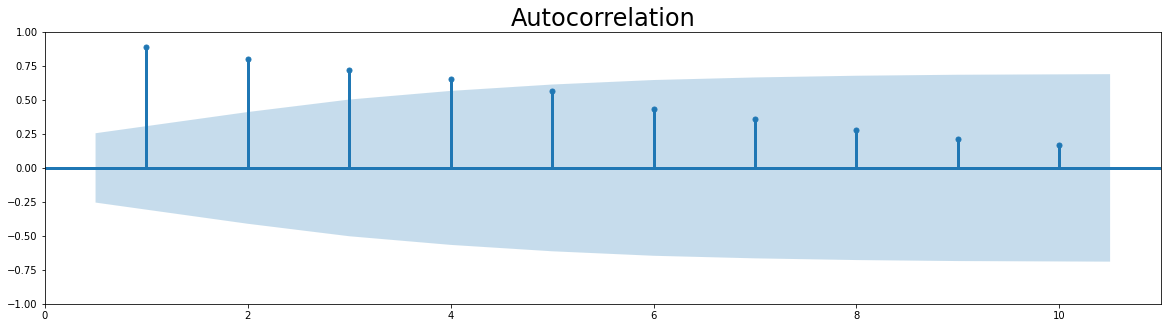

In [77]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df['GDP (current US$)'], lags=10, zero=False) 
plt.show()

Корреляция идет на убыль с течением времени.

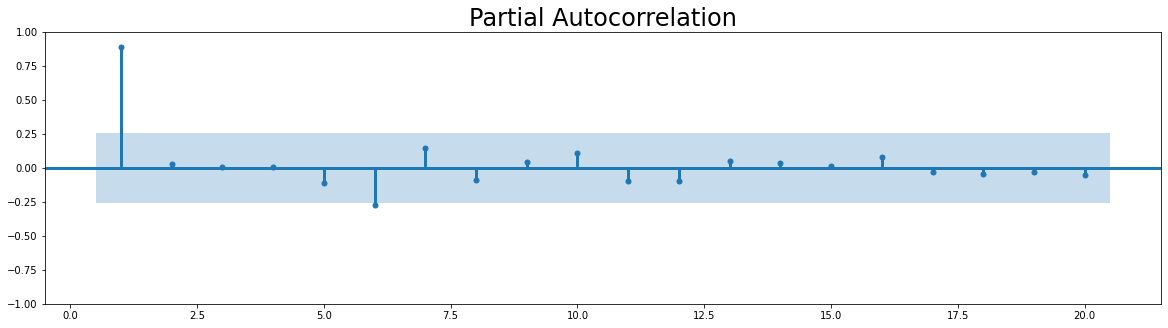

In [58]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df['GDP (current US$)'], lags=20, method="ywm", zero=False)
plt.show()

Эти графики показывают, как данные коррелируют с запаздывающей версией самих себя.
В отличие от того, что предлагали графики ACF, ВВП с лагом не приносят никакой новой информации. В таких ситуация параметр p выбирается =1


In [59]:
from statsmodels.tsa.stattools import adfuller

adfuller(train_df['GDP (current US$)'])

(0.6529066974885412,
 0.9888496277665573,
 10,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 2194.301372914139)

In [65]:
test1 = adfuller(train_df['GDP (current US$)'])
print("adf: ", test1[0])
print("p-value: ", test1[1])
print("Critical values: ", test1[4])
if test1[0] > test1[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  0.6529066974885412
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


Статистика теста больше всех критических значений, поэтому нулевую гипотезу ($H_0$) нельзя отвергнуть.

Поэтому наш ряд не являются стационарными

In [139]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=15)
    sgt.plot_pacf(series, ax=axes[1], lags=15, method="ywm")
    plt.show()

## Дифференцирование ряда
$y\_new_t = y_t - y_{t-1}$

where, 
- $y\_new_t$: Дифференцированное значение ряда $t$
- $y_t$: Фактическое значение ряда $t$
- $y_{t-1}$: Фактическое значение ряда $t-1$

In [79]:
def d_determination(series, crit=5):
    crit = str(crit) + "%"
    d = 1
    while True:
        series_new = series.diff(d).dropna()
        test = adfuller(series_new)
        if test[0] < test[4][crit]:
            return d, series_new
        d += 1

In [81]:
# Определим параметр d
d, ser = d_determination(train_df['GDP (current US$)'])
print('Параметр d равен {}.'.format(d))

Параметр d равен 2.


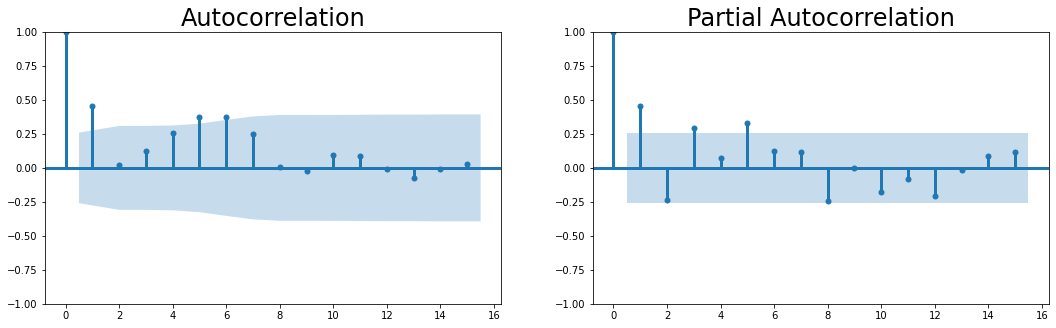

In [83]:
plot_acf_pacf(ser)

Судя по карелограмме, p=3, q=6. 
Так как ряд не стационарен будем использовать модель ARIMA.

## ARIMA

Начнем построение модели **ARIMA** со следующими параметрами:

- p = 3
- d = 2
- q = 6



In [84]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(3, 2, 6))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

/Users/sev/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/sev/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/sev/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/sev/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(3, 2, 6)   Log Likelihood               -1332.968
Date:                Wed, 02 Aug 2023   AIC                           2685.935
Time:                        16:31:30   BIC                           2706.366
Sample:                    01-01-1960   HQIC                          2693.875
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4037      0.373      1.083      0.279      -0.327       1.134
ar.L2         -0.4178      0.352     -1.185      0.236      -1.109       0.273
ar.L3         -0.2484      0.555     -0.448      0.654      -1.336       0.839
ma.L1         -1.5260      0.471     -3.242      0.001      -2.449      -0.604
ma.L2          0.9078      1.005      0.903      0.366      -1.062       2.878
ma.L3          0.2651      1.360      0.195      0.845      -2.401       2.931
ma.L4         -1.1543      1.124     -1.027      0.305      -3.358       1.050
ma.L5          1.3004      0.554      2.346      0.019       0.214       2.387
ma.L6         -0.5939      0.279     -2.127      0.033      -1.141      -0.047
sigma2      1.999e+19   1.18e-18    1.7e+37      0.000       2e+19       2e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                81.58
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):             125.00   Skew:                             1.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.82e+53. Standard errors may be unstable.
"""

In [86]:

import pmdarima as pm

In [87]:
smodel = pm.auto_arima(
    train_df['GDP (current US$)'],
    start_p=1,
    d=2,
    start_q=1,
    max_p=10,
    max_q=10,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.416, Time=0.25 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.959, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2704.667, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2683.622, Time=0.08 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=2681.414, Time=0.28 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=2680.988, Time=0.65 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=1.29 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=2680.765, Time=1.07 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=2686.992, Time=0.58 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=2682.648, Time=0.73 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=2682.800, Time=0.49 sec
 ARIMA(0,2,4)(0,0,0)[0]             : AIC=2688.234, Time=0.72 sec
 ARIMA(2,2,4)(0,0,0)[0]             : AIC=2683.409, Time=1.11 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=2686.657, Time=0.99 sec

Best model:  ARIMA(1,2,3)(0,0,0)[0]  

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.382
Date:                Wed, 02 Aug 2023   AIC                           2680.765
Time:                        16:33:27   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.33e+55. Standard errors may be unstable.
"""

Второй столбец раздела I содержит некоторые полезные показатели, которые используются для сравнения различных моделей ARIMA. Как правило, модель с более высоким логарифмическим правдоподобием или более низким IC (AIC, BIC или HQIC) лучше, и наоборот.

In [88]:

from statsmodels.tsa.arima.model import ARIMA

In [90]:
arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(1, 2, 3))
arima_model_fit_2 = arima_model.fit()
arima_model_fit_2.summary()

/Users/sev/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/sev/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/sev/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.382
Date:                Wed, 02 Aug 2023   AIC                           2680.765
Time:                        16:34:41   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.33e+55. Standard errors may be unstable.
"""

In [97]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = arima_model_fit_2.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["GDP"] = data["GDP (current US$)"]

forecast = arima_model_fit_2.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

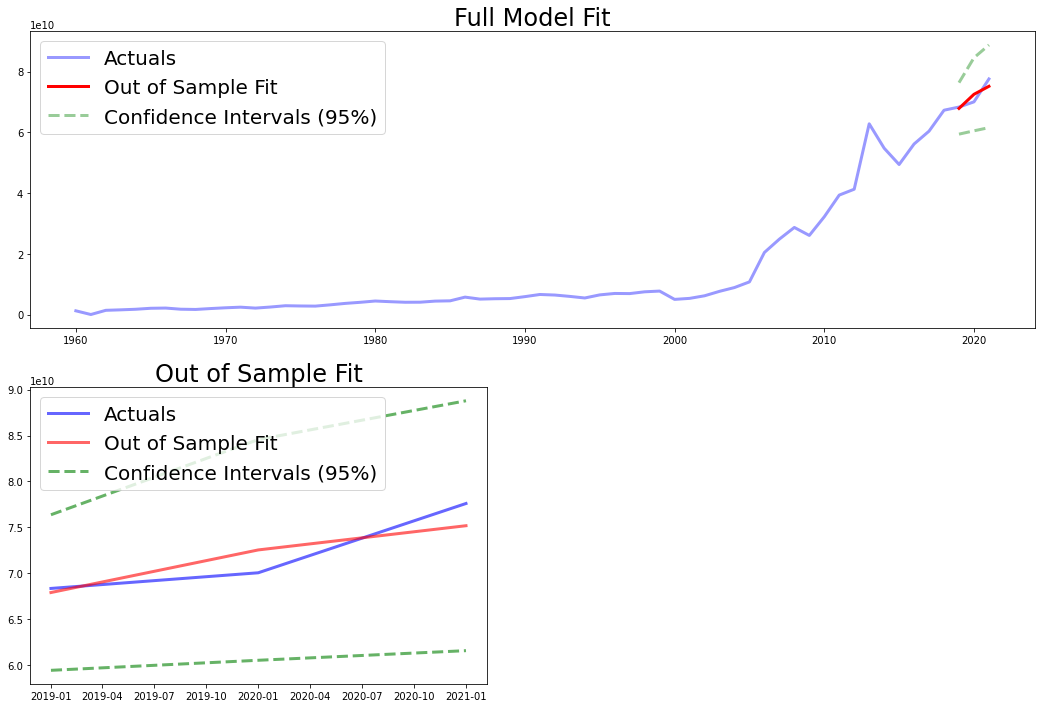

In [98]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

In [99]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["GDP"] = data["GDP (current US$)"]

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

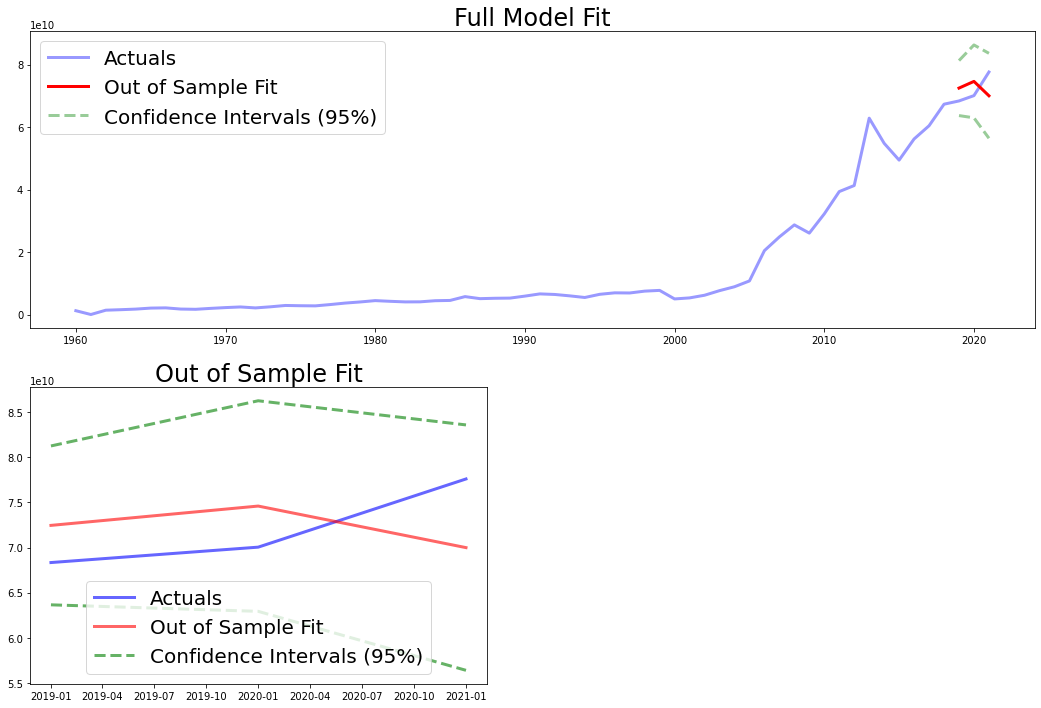

In [100]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

Вывод: 
Лучше  предсказывает модель, выбранная по оптимальным параметрам с помощью auto_arima (1, 2, 3). 
Модель, построенная на данных карелограммы, показала себя хуже, никакого снижения ВВП не было.

Проверка на пропуски:

In [101]:
print('Записей до обработки пропусков с помощью метода asfreq: {}.'.format(data.shape[0]))
data = data.asfreq(freq='AS')
print('Записей после обработки пропусков с помощью метода asfreq: {}.'.format(data.shape[0]))

Записей до обработки пропусков с помощью метода asfreq: 62.
Записей после обработки пропусков с помощью метода asfreq: 62.


In [102]:
data.isna().sum()

GDP (current US$)    0
dtype: int64

In [103]:
import numpy as np

In [104]:
data["GDP (current US$)"] = data["GDP (current US$)"].apply(lambda x: np.nan if x == 0 else x)

In [105]:
data.isna().sum()

GDP (current US$)    1
dtype: int64

Было одно значение равное 0.

In [106]:
data["GDP (current US$)"].interpolate(method='linear', inplace=True)

In [107]:
train_df = data.iloc[:-3]
test_df = data.iloc[-3:]
train_df.shape, test_df.shape

((59, 1), (3, 1))

In [109]:
test = adfuller(train_df['GDP (current US$)'])
print("adf: ", test[0])
print("p-value: ", test[1])
print("Critical values: ", test[4])
if test[0] > test[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  0.8030073326980112
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


In [110]:
d, ser = d_determination(train_df['GDP (current US$)'])
print('Параметр d равен {}.'.format(d))

Параметр d равен 2.


In [112]:
smodel = pm.auto_arima(
    train_df['GDP (current US$)'],
    start_p=1,
    d=2,
    start_q=1,
    max_p=10,
    max_q=10,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.377, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.683, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2704.584, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2683.547, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=2681.389, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=2680.921, Time=0.13 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=2680.513, Time=0.18 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=2687.184, Time=0.08 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=2682.393, Time=0.25 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=2682.617, Time=0.15 sec
 ARIMA(0,2,4)(0,0,0)[0]             : AIC=2687.812, Time=0.13 sec
 ARIMA(2,2,4)(0,0,0)[0]             : AIC=2683.040, Time=0.22 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=2686.809, Time=0.28 sec

Best model:  ARIMA(1,2,3)(0,0,0)[0]  

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.257
Date:                Wed, 02 Aug 2023   AIC                           2680.513
Time:                        19:49:53   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.58e+54. Standard errors may be unstable.
"""

In [113]:
arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(3, 2, 6))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

/Users/sev/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(3, 2, 6)   Log Likelihood               -1332.819
Date:                Wed, 02 Aug 2023   AIC                           2685.638
Time:                        19:50:31   BIC                           2706.069
Sample:                    01-01-1960   HQIC                          2693.578
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4362      0.434      1.006      0.314      -0.414       1.286
ar.L2         -0.4644      0.353     -1.314      0.189      -1.157       0.228
ar.L3         -0.1720      0.581     -0.296      0.767      -1.310       0.966
ma.L1         -1.5686      0.503     -3.116      0.002      -2.555      -0.582
ma.L2          1.0344      1.009      1.025      0.306      -0.944       3.013
ma.L3          0.0724      1.319      0.055      0.956      -2.512       2.657
ma.L4         -1.0094      1.004     -1.005      0.315      -2.978       0.959
ma.L5          1.2761      0.470      2.716      0.007       0.355       2.197
ma.L6         -0.5997      0.289     -2.077      0.038      -1.166      -0.034
sigma2      2.017e+19   1.61e-20   1.25e+39      0.000    2.02e+19    2.02e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                76.44
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):             185.95   Skew:                             1.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.21e+55. Standard errors may be unstable.
"""

AIC критерий построенной модели по сравнению с моделью на неинтерполированных данных не изменился, пропуск одного значения не повлиял на значение критерия AIC (ни в одной из моделей).

In [114]:
from sklearn.model_selection import TimeSeriesSplit

In [115]:
tscv = TimeSeriesSplit(n_splits=3, test_size=7)

In [117]:
train_test_groups = tscv.split(data) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 41 TEST size: 7
TRAIN size: 48 TEST size: 7
TRAIN size: 55 TEST size: 7


Волатильность

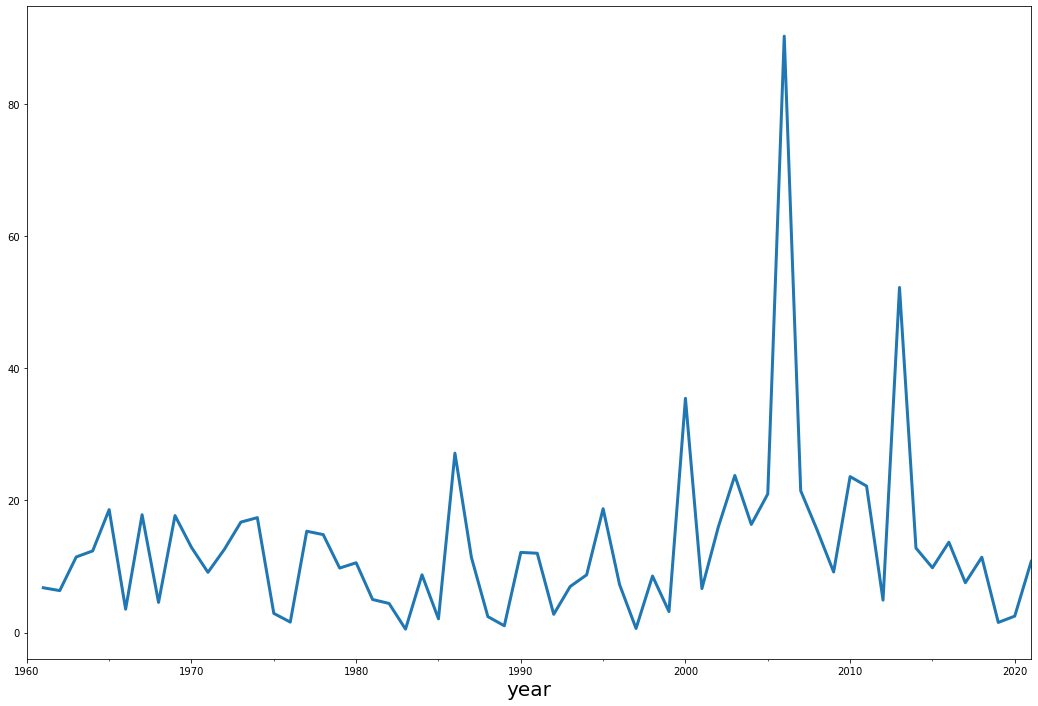

In [118]:
data["GDP_vol"] = data['GDP (current US$)'].pct_change(1).mul(100).abs()

data["GDP_vol"].plot()
plt.show()

In [120]:
train_df = data.iloc[:-3]
test_df = data.iloc[-3:]

In [121]:
smodel = pm.auto_arima(
    train_df.GDP_vol.dropna(),
    start_p=1,
    d=2,
    start_q=1,
    max_p=10,
    max_q=10,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=548.939, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=519.421, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=505.554, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=497.605, Time=0.05 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=492.922, Time=0.07 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=492.767, Time=0.09 sec
 ARIMA(6,2,0)(0,0,0)[0]             : AIC=485.218, Time=0.10 sec
 ARIMA(7,2,0)(0,0,0)[0]             : AIC=480.892, Time=0.13 sec
 ARIMA(8,2,0)(0,0,0)[0]             : AIC=481.493, Time=0.14 sec
 ARIMA(7,2,1)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(6,2,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(8,2,1)(0,0,0)[0]             : AIC=inf, Time=0.63 sec
 ARIMA(7,2,0)(0,0,0)[0] intercept   : AIC=482.802, Time=0.20 sec

B

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(7, 2, 0)   Log Likelihood                -232.446
Date:                Thu, 03 Aug 2023   AIC                            480.892
Time:                        17:48:24   BIC                            497.095
Sample:                    01-01-1961   HQIC                           487.174
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6191      0.100    -16.215      0.000      -1.815      -1.423
ar.L2         -1.8717      0.217     -8.622      0.000      -2.297      -1.446
ar.L3         -1.8602      0.343     -5.418      0.000      -2.533      -1.187
ar.L4         -1.6430      0.449     -3.660      0.000      -2.523      -0.763
ar.L5         -1.2935      0.393     -3.293      0.001      -2.063      -0.524
ar.L6         -0.8934      0.284     -3.141      0.002      -1.451      -0.336
ar.L7         -0.3364      0.198     -1.697      0.090      -0.725       0.052
sigma2       218.7368     33.298      6.569      0.000     153.473     284.000
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):               109.07
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):              10.86   Skew:                             1.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [122]:
test = adfuller(train_df.GDP_vol[1:])
print("adf: ", test[0])
print("p-value: ", test[1])
print("Critical values: ", test[4])
if test[0] > test[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  -6.725311059553779
p-value:  3.4014596148856493e-09
Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
ряд стационарен


In [123]:
garch_df = pd.DataFrame(data["GDP_vol"].loc[data.index])
garch_df.loc[train_df.index, "GDP_vol"] = train_df["GDP_vol"].dropna()

In [125]:

from arch import arch_model

In [126]:
model = arch_model(garch_df["GDP_vol"].dropna(), p=7, q=0, vol='GARCH')
model_results = model.fit(last_obs=test_df.index[0], update_freq=5)
model_results.summary()

Iteration:      5,   Func. Count:     55,   Neg. LLF: 217.44764981117177
Iteration:     10,   Func. Count:    107,   Neg. LLF: 216.9744085936657
Iteration:     15,   Func. Count:    159,   Neg. LLF: 889.0900487962847
Iteration:     20,   Func. Count:    212,   Neg. LLF: 214.0078660016918
Optimization terminated successfully    (Exit mode 0)
            Current function value: 214.0074931883244
            Iterations: 23
            Function evaluations: 241
            Gradient evaluations: 23


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                GDP_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -214.007
Distribution:                  Normal   AIC:                           446.015
Method:            Maximum Likelihood   BIC:                           464.559
                                        No. Observations:                   58
Date:                Thu, Aug 03 2023   Df Residuals:                       57
Time:                        17:49:50   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.8577      1.325      8.951  3.516e-19 [  9.261, 14.454]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         44.2349     13.740      3.219  1.285e-03      [ 17.304, 71.165]
alpha[1]       0.0000  4.575e-02      0.000      1.000 [-8.967e-02,8.967e-02]
alpha[2]       0.0000  1.313e-02      0.000      1.000 [-2.574e-02,2.574e-02]
alpha[3]       0.0000  2.876e-02      0.000      1.000 [-5.637e-02,5.637e-02]
alpha[4]   3.5931e-03  4.736e-03      0.759      0.448 [-5.689e-03,1.287e-02]
alpha[5]       0.0000  8.569e-03      0.000      1.000 [-1.679e-02,1.679e-02]
alpha[6]       0.7330      0.486      1.509      0.131      [ -0.219,  1.685]
alpha[7]       0.1023  5.610e-02      1.824  6.818e-02   [-7.638e-03,  0.212]
=============================================================================

Covariance estimator: robust
"""

In [127]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
    test_df.index
]

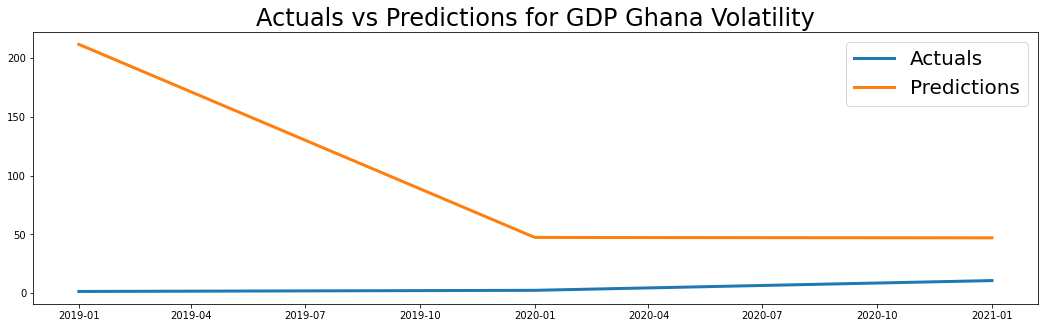

In [135]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["GDP_vol"].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for GDP Ghana Volatility", size=24)
plt.legend(["Actuals","Predictions"])

plt.show()

In [130]:
import numpy as np
from sklearn.metrics import mean_squared_error

mean_squared_error(
    predictions_df["GDP_vol"].abs(), predictions_df["Predictions"]
)

15817.776862171377

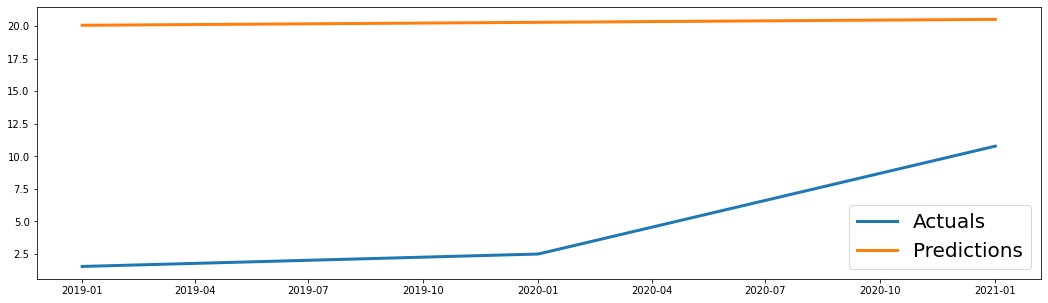

In [138]:
from sklearn.linear_model import LinearRegression

X_train = pd.DataFrame(range(data["GDP_vol"].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(data["GDP_vol"].shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df["GDP_vol"].fillna(0)
y_test = test_df["GDP_vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))

plt.legend(["Actuals","Predictions"])
plt.show()

Обе модели далеки от истины, скорее всего специфика данных.